# Pytorch Lab: GLM
# HW 6
## 학과: 경영학부
## 학번: 1985084
## 이름: 임수지
## 영상 링크: https://youtu.be/bZTYNlbNLLs?si=ENVg5hE5W0bZVyA1

## 1. Revisiting Linear Regression

### 1.1 Data Generation

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(452)
n = 2000 #first 1000 are train and others are test
x1 = torch.randn(n)                    
x2 = torch.normal(mean=0.0, std=2.0, size=(n,))  
x3 = torch.bernoulli(torch.full((n,), 0.5))      

y = 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


In [14]:
betas = torch.tensor(torch.randn([4,1]), requires_grad=True) # [4,1]
sigma = torch.tensor(torch.randn([1,]), requires_grad=True) # [1, ]
optimizer = torch.optim.SGD([betas, sigma], lr=0.001)

/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_74382/938838282.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas = torch.tensor(torch.randn([4,1]), requires_grad=True) # [4,1]
/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_74382/938838282.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(torch.randn([1,]), requires_grad=True) # [1, ]


### 1.7 Exercise & HW (Video Recording) 영상: https://youtu.be/bZTYNlbNLLs?si=ENVg5hE5W0bZVyA1 0:00~1:12

Use the following custom layer to train the model again and calculate the test mse. Note that you have both forward function and loss function inside 

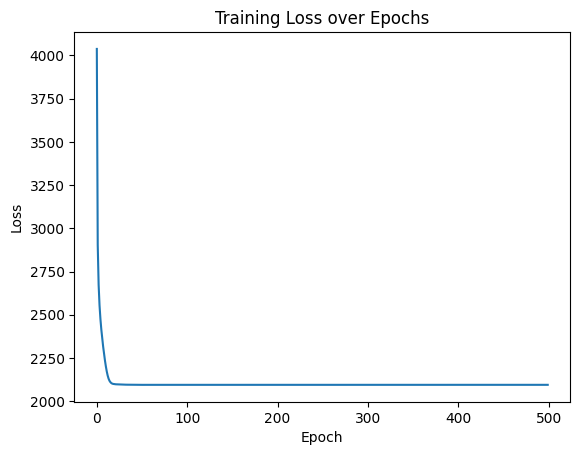

Learned parameters:
Betas: tensor([[ 1.9299,  0.8325, -1.1968,  3.0252]])
Sigma: tensor([-1.9659])

True parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0

Test MSE: 4.0736


In [15]:
import torch.nn as nn

class GaussianRegModel(nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))
        self.sigma = torch.nn.Parameter(torch.randn([1,]))  # ensures sigma > 0

    def forward(self, X):
        mu = X @ self.betas
        return mu

    def loss(self, mu, y):
        ll = -1/2*torch.log(2*torch.pi*self.sigma**2) - (y - mu)**2/(2*self.sigma**2)
        nll = -torch.sum(ll)
        return nll

# Initialize model and optimizer
model = GaussianRegModel(p=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        mu = model.forward(xx)
        loss = model.loss(mu, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

print("Learned parameters:")
print("Betas:", model.betas.data.T)
print("Sigma:", model.sigma.data)
print("\nTrue parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = model.forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

### 1.8 HW

Use `torch.nn.Linear` layer to train the model again and calculate the test mse.

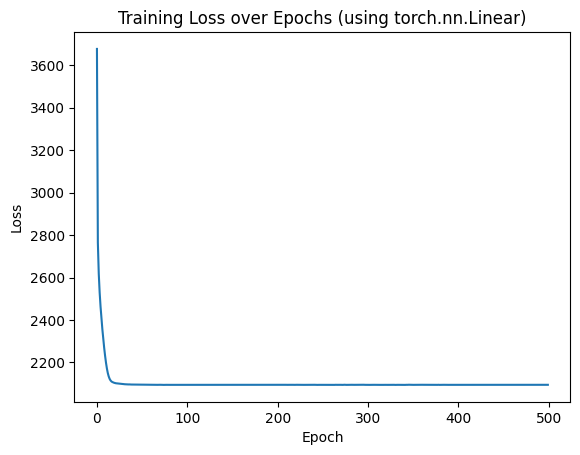

Learned parameters:
Betas (from Linear layer): tensor([[ 1.9299,  0.8318, -1.1933,  3.0250]])
Sigma: tensor([1.9709])

True parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0

Test MSE: 4.0730


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Regenerate data with same seed for consistency
torch.manual_seed(452)
n = 2000
x1 = torch.randn(n)                    
x2 = torch.normal(mean=0.0, std=2.0, size=(n,))  
x3 = torch.bernoulli(torch.full((n,), 0.5))      

y = 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


# Define model with torch.nn.Linear and custom loss
class GaussianRegLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Use Linear layer without bias since we already have intercept in X
        self.linear = nn.Linear(input_dim, 1, bias=False)
        self.sigma = nn.Parameter(torch.randn([1,]))
    
    def forward(self, X):
        mu = self.linear(X)
        return mu
    
    def loss(self, mu, y):
        ll = -1/2*torch.log(2*torch.pi*self.sigma**2) - (y - mu)**2/(2*self.sigma**2)
        nll = -torch.sum(ll)
        return nll


# Initialize model and optimizer
model = GaussianRegLinear(input_dim=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        mu = model.forward(xx)
        loss = model.loss(mu, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (using torch.nn.Linear)')
plt.show()

print("Learned parameters:")
print("Betas (from Linear layer):", model.linear.weight.data)
print("Sigma:", model.sigma.data)
print("\nTrue parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = model.forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

## 2. Poisson regression

### 2.1 Data Generation

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.manual_seed(452)
n = 2000 #first 1000 are train and others are test
x1 = torch.randn(n)                    
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))      

mu = torch.exp(-2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3 )
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)


poisson_dist = torch.distributions.Poisson(mu)
y = poisson_dist.sample()


train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)



In [18]:
betas = torch.tensor(torch.randn([4, 1]), requires_grad=True)
optimizer = torch.optim.SGD([betas], lr=0.001)
    

/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_74382/554553368.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas = torch.tensor(torch.randn([4, 1]), requires_grad=True)


### 2.7 Exercise & HW (Video Recording) 영상: https://youtu.be/bZTYNlbNLLs?si=ENVg5hE5W0bZVyA1 1:13~1:56

Use the following custom layer to train the model again and calculate the test mse. Note that you have both forward function and loss function inside custom layer.

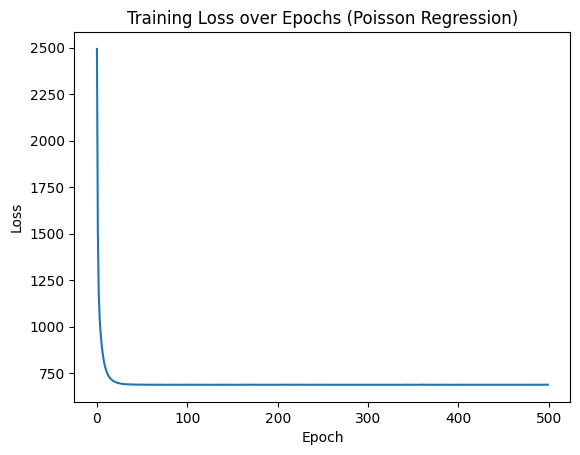

Learned parameters:
Betas: tensor([[-2.0060,  0.3744, -1.1802,  1.0213]])

True parameters: [-2.0, 0.4, -1.2, 1.0]

Test MSE: 0.4147


In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class PoissonRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))

    def forward(self, X):
        lam = torch.exp(X @ self.betas)
        return lam

    def loss(self, lam, y):        
        ll = -lam + y * torch.log(lam) - torch.lgamma(y + 1)
        return -torch.sum(ll)           


# Initialize model and optimizer
forward = PoissonRegModel(4)
optimizer = torch.optim.SGD(forward.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        lam = forward(xx)
        loss = forward.loss(lam, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Poisson Regression)')
plt.show()

print("Learned parameters:")
print("Betas:", forward.betas.data.T)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

### 2.8 HW

Use `torch.nn.Linear` layer to train the model again and calculate the test mse.

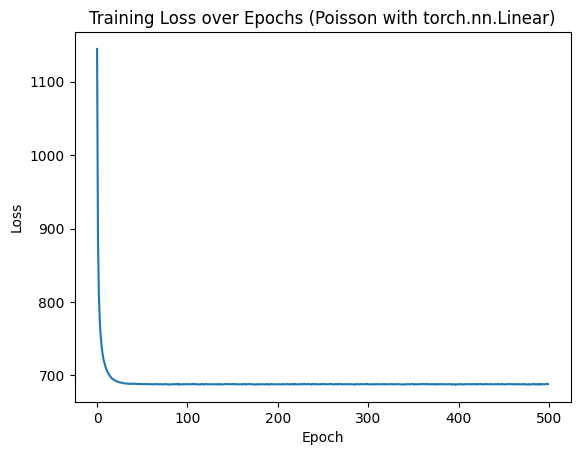

Learned parameters:
Betas (from Linear layer): tensor([[-2.0027,  0.3742, -1.1836,  1.0245]])

True parameters: [-2.0, 0.4, -1.2, 1.0]

Test MSE: 0.4166


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Regenerate data with same seed for consistency
torch.manual_seed(452)
n = 2000
x1 = torch.randn(n)                    
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))      

mu = torch.exp(-2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3)
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

poisson_dist = torch.distributions.Poisson(mu)
y = poisson_dist.sample()

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


# Define model with torch.nn.Linear
class PoissonRegLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Use Linear layer without bias since we already have intercept in X
        self.linear = nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, X):
        lam = torch.exp(self.linear(X))
        return lam
    
    def loss(self, lam, y):
        ll = -lam + y * torch.log(lam) - torch.lgamma(y + 1)
        nll = -torch.sum(ll)
        return nll


# Initialize model and optimizer
model = PoissonRegLinear(input_dim=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        lam = model.forward(xx)
        loss = model.loss(lam, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Poisson with torch.nn.Linear)')
plt.show()

print("Learned parameters:")
print("Betas (from Linear layer):", model.linear.weight.data)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = model.forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

## 3. Logistic regression

### 3.1 Data Generation

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.manual_seed(452)
n = 2000  # first 1000 train, next 1000 test

# Covariates
x1 = torch.randn(n)
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))   # binary covariate

# Linear predictor (logit scale)
eta = -2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3

# Bernoulli probability using sigmoid
p = torch.sigmoid(eta)

# Generate Bernoulli response
bernoulli_dist = torch.distributions.Bernoulli(probs=p)
y = bernoulli_dist.sample()

# Design matrix
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

# Train/Test split
train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)



In [22]:
betas = torch.tensor(torch.randn([4,1]), requires_grad=True)
optimizer = torch.optim.SGD([betas], lr=0.001)

/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_74382/1601251795.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas = torch.tensor(torch.randn([4,1]), requires_grad=True)


### 3.8 Exercise & HW (Video Recording) 영상: https://youtu.be/bZTYNlbNLLs?si=ENVg5hE5W0bZVyA1 1:57~3:00

Use the following custom layer to train the model again and calculate the test mse as well as test accuracy. Note that you have both forward function and loss function inside custom layer.

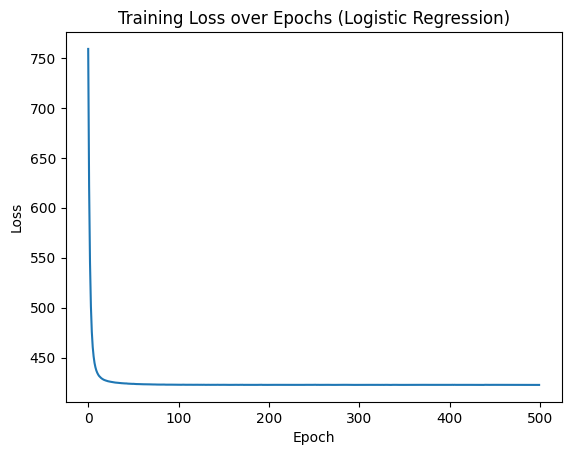

Learned parameters:
Betas: tensor([[-2.1606,  0.3592, -1.2045,  1.1523]])

True parameters: [-2.0, 0.4, -1.2, 1.0]

Test MSE: 0.1411
Test Accuracy: 0.7990
Test Accuracy: 79.90%


In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class LogisticRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))

    def forward(self, X):
        pp = torch.sigmoid(X @ self.betas)
        return pp

    def loss(self, pp, y):        
        ll = y * torch.log(pp) + (1 - y) * torch.log(1 - pp)
        return -torch.sum(ll)           


# Initialize model and optimizer
forward = LogisticRegModel(4)
optimizer = torch.optim.SGD(forward.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        pp = forward(xx)
        loss = forward.loss(pp, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Logistic Regression)')
plt.show()

print("Learned parameters:")
print("Betas:", forward.betas.data.T)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    pp_hat = forward(xx)
    sum_square += torch.sum((yy - pp_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

# Calculate Test Accuracy
sum_correct = 0
for xx, yy in test_loader:
    # predicted probability
    pp_hat = forward(xx)
    
    # convert to 0/1 prediction
    yy_hat = (pp_hat >= 0.5).float()
    
    # count correct predictions
    sum_correct += torch.sum(yy == yy_hat).item()

# compute accuracy
test_accuracy = sum_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

### 3.9 HW

Use `torch.nn.Linear` layer to train the model again and calculate the test mse as well as test accuracy.

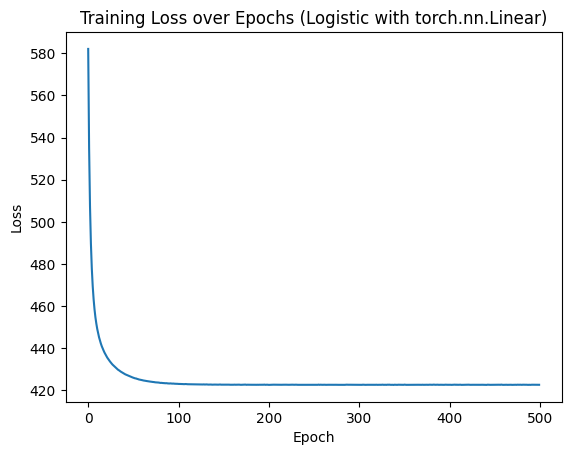

Learned parameters:
Betas (from Linear layer): tensor([[-2.1598,  0.3588, -1.2049,  1.1528]])

True parameters: [-2.0, 0.4, -1.2, 1.0]

Test MSE: 0.1411
Test Accuracy: 0.7990
Test Accuracy: 79.90%


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Regenerate data with same seed for consistency
torch.manual_seed(452)
n = 2000

# Covariates
x1 = torch.randn(n)
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))

# Linear predictor (logit scale)
eta = -2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3

# Bernoulli probability using sigmoid
p = torch.sigmoid(eta)

# Generate Bernoulli response
bernoulli_dist = torch.distributions.Bernoulli(probs=p)
y = bernoulli_dist.sample()

# Design matrix
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

# Train/Test split
train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


# Define model with torch.nn.Linear
class LogisticRegLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Use Linear layer without bias since we already have intercept in X
        self.linear = nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, X):
        pp = torch.sigmoid(self.linear(X))
        return pp
    
    def loss(self, pp, y):
        ll = y * torch.log(pp) + (1 - y) * torch.log(1 - pp)
        nll = -torch.sum(ll)
        return nll


# Initialize model and optimizer
model = LogisticRegLinear(input_dim=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        pp = model.forward(xx)
        loss = model.loss(pp, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Logistic with torch.nn.Linear)')
plt.show()

print("Learned parameters:")
print("Betas (from Linear layer):", model.linear.weight.data)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    pp_hat = model.forward(xx)
    sum_square += torch.sum((yy - pp_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

# Calculate Test Accuracy
sum_correct = 0
for xx, yy in test_loader:
    # predicted probability
    pp_hat = model.forward(xx)
    
    # convert to 0/1 prediction
    yy_hat = (pp_hat >= 0.5).float()
    
    # count correct predictions
    sum_correct += torch.sum(yy == yy_hat).item()

# compute accuracy
test_accuracy = sum_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")